# AIR

In [9]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import IndexLocator
from matplotlib import patches
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error as rmse
from utils import Vectorize, R_opt_pro, R_inv
from Generate_XnY import *
from AIR import AIR
rng = np.random.RandomState(777)

In [2]:
n = 4000
r = 0.8
N = int(n / r)
shape = (28, 28)
blockshape = (4, 4)
idctshape = tuple((np.array(shape) / np.array(blockshape)).astype(int))
DI_EXP = 0.5
noise_level = 1

settings = {'method': 'ByW', 'N': N, 'shape': shape, 'blockshape': blockshape, 'DI_EXP': DI_EXP, 'noise_level': noise_level, 'random_state': 0}
(X, Y), (C, D, W), ROI_COOR = Generate_XnY(**settings)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=r, random_state=0)
RX = np.array([R_opt_pro(x, idctshape)[1] for x in X])
RX_train = np.array([R_opt_pro(x, idctshape)[1] for x in X_train])
RX_test = np.array([R_opt_pro(x, idctshape)[1] for x in X_test])
train, valid = (RX_train, Y_train.ravel()), (RX_test, Y_test.ravel())

_, RC = R_opt_pro(C, idctshape)
_, RD = R_opt_pro(D, idctshape)
p, d = RC.shape

print(f'Degree of individuation: {DI_EXP:.1f}')
print(f'Y | Mean: {Y.mean():.3f}, Variance: {Y.var():.3f} (s.d.: {Y.std():.3f}), Max abs: {np.abs(Y).max():.3f}')

Degree of individuation: 0.5
Y | Mean: -2.857, Variance: 320.391 (s.d.: 17.899), Max abs: 72.239


In [3]:
''' Linear Regression '''
lr = LinearRegression(fit_intercept=False)
lr.fit(Vectorize(RX_train), Y_train)
RC_hat_OLS = lr.coef_.reshape(RC.shape)
C_hat_OLS = R_inv(RC_hat_OLS, blockshape, idctshape)
Y_inhat = lr.predict(Vectorize(RX_train))
Y_outhat = lr.predict(Vectorize(RX_test))
RMSE_OLS_train = rmse(Y_train, Y_inhat)
RMSE_OLS_test = rmse(Y_test, Y_outhat)

## AIR

In [4]:
''' AIR '''
print('AIR...')
print(f'Number of parameters: {2 * p * d + d * d} = {p * d} x {2} + {d * d}')
air = AIR()
Init_method = 'Init_W'
Init_Dict = {'C': None, 'D': None, 'W': None}

lams = [1e-3, 1, 0]
max_itr = 50
params, records = air.fit(train=train, valid=valid, lams=lams, max_itr=max_itr, init=Init_method, init_dict=Init_Dict)
RC_hat, RD_hat, W_hat = params

AIR...
Number of parameters: 1824 = 784 x 2 + 256
Lambda | C: 0.001, D: 1, W: 0
Initializing W... | Finished.
Iteration: 01 | RMSE | Train: 1.027, Valid: 1.705
Iteration: 02 | RMSE | Train: 0.984, Valid: 1.678
Iteration: 03 | RMSE | Train: 0.962, Valid: 1.668
Iteration: 04 | RMSE | Train: 0.948, Valid: 1.665
Iteration: 05 | RMSE | Train: 0.937, Valid: 1.664
Iteration: 06 | RMSE | Train: 0.930, Valid: 1.664
Iteration: 07 | RMSE | Train: 0.923, Valid: 1.663
Iteration: 08 | RMSE | Train: 0.918, Valid: 1.662
Iteration: 09 | RMSE | Train: 0.913, Valid: 1.659
Iteration: 10 | RMSE | Train: 0.908, Valid: 1.656
Iteration: 11 | RMSE | Train: 0.904, Valid: 1.652
Iteration: 12 | RMSE | Train: 0.899, Valid: 1.647
Iteration: 13 | RMSE | Train: 0.894, Valid: 1.640
Iteration: 14 | RMSE | Train: 0.888, Valid: 1.633
Iteration: 15 | RMSE | Train: 0.883, Valid: 1.623
Iteration: 16 | RMSE | Train: 0.876, Valid: 1.612
Iteration: 17 | RMSE | Train: 0.868, Valid: 1.600
Iteration: 18 | RMSE | Train: 0.859, Val

In [5]:
C_hat_AIR = R_inv(RC_hat, blockshape, idctshape)
D_hat = R_inv(RD_hat, blockshape, idctshape)
Y_inhat = air.predict(RX_train)
Y_outhat = air.predict(RX_test)
RMSE_AIR_train = rmse(Y_train, Y_inhat)
RMSE_AIR_test = rmse(Y_test, Y_outhat)

RMSE_OLS = rmse(C, C_hat_OLS)
RMSE_AIR = rmse(C, C_hat_AIR)
print(f'RMSE for OLS | Estimation: {RMSE_OLS:.3f} | Prediction: {RMSE_OLS_train:.3f} (Train) and {RMSE_OLS_test:.3f} (Test)')
print(f'RMSE for AIR | Estimation: {RMSE_AIR:.3f} | Prediction: {RMSE_AIR_train:.3f} (Train) and {RMSE_AIR_test:.3f} (Test)')
Y_homo_AIR = np.array([np.vdot(Xi, C_hat_AIR) for Xi in X])
Y_hete_AIR = np.array([np.vdot(RXi.dot(W_hat).dot(RXi.T).dot(RXi), RD_hat) for RXi in RX])
L2_homo, L2_hete = np.linalg.norm(Y_homo_AIR), np.linalg.norm(Y_hete_AIR)
print(f'Degree of individuation: {L2_hete / L2_homo:.2f} = {L2_hete:.0f} / {L2_homo:.0f}')

RMSE for OLS | Estimation: 0.187 | Prediction: 2.425 (Train) and 3.130 (Test)
RMSE for AIR | Estimation: 0.038 | Prediction: 0.725 (Train) and 1.360 (Test)
Degree of individuation: 0.50 = 695 / 1385


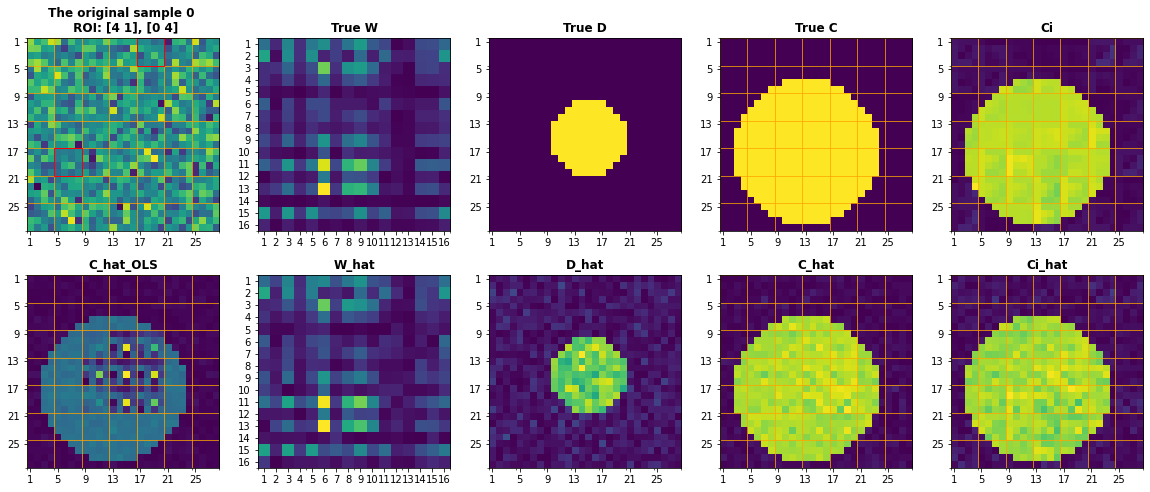

In [8]:
i = 0
Xi = X[i]
roi_coor = ROI_COOR[i]
_, RXi = R_opt_pro(Xi, idctshape)
Ai = RXi.dot(W).dot(RXi.T)
Ai_hat = RXi.dot(W_hat).dot(RXi.T)
Ci = R_inv(RC + Ai.T.dot(RD), blockshape, idctshape)
Ci_hat = R_inv(RC_hat + Ai_hat.T.dot(RD_hat), blockshape, idctshape)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
visualize(axes[0, 0], Xi, coordinates=roi_coor, num_yx=idctshape, grid=True, title=f'The original sample {i} \n ROI: {", ".join([str(yx) for yx in roi_coor])}')
visualize(axes[0, 1], np.abs(W), num_yx=W_hat.shape, grid=False, title=f'True W')
visualize(axes[0, 2], np.abs(D), num_yx=idctshape, grid=False, title=f'True D')
visualize(axes[0, 3], np.abs(C), num_yx=idctshape, grid=True, title='True C')
visualize(axes[0, 4], np.abs(Ci), num_yx=idctshape, grid=True, title='Ci')
visualize(axes[1, 0], np.abs(C_hat_OLS), num_yx=idctshape, grid=True, title=f'C_hat_OLS')
visualize(axes[1, 1], np.abs(W_hat), num_yx=W_hat.shape, grid=False, title=f'W_hat')
visualize(axes[1, 2], np.abs(D_hat), num_yx=idctshape, grid=False, title=f'D_hat')
visualize(axes[1, 3], np.abs(C_hat_AIR), num_yx=idctshape, grid=True, title='C_hat')
visualize(axes[1, 4], np.abs(Ci_hat), num_yx=idctshape, grid=True, title='Ci_hat')
plt.show()